<a href="https://colab.research.google.com/github/abulhasanat/MachineLearning/blob/master/CNN_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Fashion-MNIST Data Set
Before we go ahead and load in the data, it's good to take a look at what we'll exactly be working with! The Fashion-MNIST dataset is a dataset of Zalando's article images, with 28x28 grayscale images of 70,000 fashion products from 10 categories, and 7,000 images per category. The training set has 60,000 images, and the test set has 10,000 images. 


# Load the Data
Keras comes with a library called datasets, which we can use to load datasets out of the box: we download the data from the server and speeds up the process since we no longer have to download the data to wer computer. The train and test images along with the labels are loaded and stored in variables train_X, train_Y, test_X, test_Y, respectively.

In [1]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

Using TensorFlow backend.


4423680/4422102 [==============================] - 1s 0us/step


# Analyze the Data
Let's now analyze how images in the dataset look like. Even though we know the dimension of the images by now, it's still worth the effort to analyze it programmatically: we might have to rescale the image pixels and resize the images.

In [2]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


From the above output, we can see that the training data has a shape of 60000 x 28 x 28 since there are 60,000 training samples each of 28 x 28 dimension. Similarly, the test data has a shape of 10000 x 28 x 28 since there are 10,000 testing samples.

In [3]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


There's also a total of ten output classes that range from 0 to 9.

Let's take a look at what the images in our dataset:

Text(0.5, 1.0, 'Ground Truth : 9')

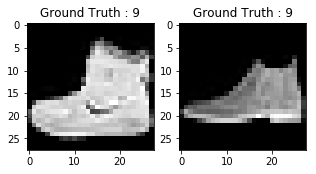

In [4]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

The output of above two plots looks like an ankle boot, and this class is assigned a class label of 9. Similarly, other fashion products will have different labels, but similar products will have same labels. This means that all the 7,000 ankle boot images will have a class label of 9.

# Data Preprocessing
As a first step, convert each 28 x 28 image of the train and test set into a matrix of size 28 x 28 x 1 which is fed into the network.

In [5]:
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

The data right now is in an int8 format, so before we feed it into the network we need to convert its type to float32, and we also have to rescale the pixel values in range 0 - 1 inclusive. So let's do that!

In [0]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

Now we need to convert the class labels into a one-hot encoding vector.

In [7]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


We will train the model on 80\% of the training data and validate it on 20\% of the remaining training data.

In [0]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

For one last time let's check the shape of training and validation set.

In [9]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

# The Network
We'll use three convolutional layers:

The first layer will have 32-3 x 3 filters,
The second layer will have 64-3 x 3 filters and
The third layer will have 128-3 x 3 filters.
In addition, there are three max-pooling layers each of size 2 x 2.

# Model the Data
First, let's import all the necessary modules required to train the model.

In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

We will use a batch size of 64 using a higher batch size of 128 or 256 is also preferable it all depends on the memory. It contributes massively to determining the learning parameters and affects the prediction accuracy. We will train the network for 20 epochs.

In [0]:
batch_size = 64
epochs = 20
num_classes = 10

# Neural Network Architecture
In Keras, we can just stack up layers by adding the desired layer one by one. That's exactly what we'll do here: we'll first add a first convolutional layer with Conv2D(). Note that we use this function because we're working with images! Next, we add the Leaky ReLU activation function which helps the network learn non-linear decision boundaries. Since we have ten different classes, we'll need a non-linear decision boundary that could separate these ten classes which are not linearly separable.

More specifically, we add Leaky ReLUs because they attempt to fix the problem of dying Rectified Linear Units (ReLUs). The ReLU activation function is used a lot in neural network architectures and more specifically in convolutional networks, where it has proven to be more effective than the widely used logistic sigmoid function. As of 2017, this activation function is the most popular one for deep neural networks. The ReLU function allows the activation to be thresholded at zero. However, during the training, ReLU units can "die". This can happen when a large gradient flows through a ReLU neuron: it can cause the weights to update in such a way that the neuron will never activate on any data point again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. Leaky ReLUs attempt to solve this: the function will not be zero but will instead have a small negative slope.

Next, we'll add the max-pooling layer with MaxPooling2D() and so on. The last layer is a Dense layer that has a softmax activation function with 10 units, which is needed for this multi-class classification problem.

In [12]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

W0716 05:14:26.653809 140549233768320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 05:14:26.693733 140549233768320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 05:14:26.700169 140549233768320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 05:14:26.729456 140549233768320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



# Compile the Model
After the model is created, we compile it using the Adam optimizer, one of the most popular optimization algorithms. 

In [13]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

W0716 05:14:31.951992 140549233768320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0716 05:14:31.961190 140549233768320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



Let's visualize the layers that you created in the above step by using the summary function. This will show some parameters (weights and biases) in each layer and also the total parameters in your model.

In [14]:
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
__________

# Train the Model
It's finally time to train the model with Keras' fit() function! The model trains for 20 epochs. The fit() function will return a history object; By storying the result of this function in fashion_train, we can use it later to plot the accuracy and loss function plots between training and validation which will help us to analyze our model's performance visually.

In [15]:
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

W0716 05:14:45.888357 140549233768320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0716 05:14:45.959022 140549233768320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 12s 247us/step - loss: 0.4721 - acc: 0.8298 - val_loss: 0.3221 - val_acc: 0.8843
Epoch 2/20
48000/48000 [==============================] - 4s 92us/step - loss: 0.2894 - acc: 0.8946 - val_loss: 0.2674 - val_acc: 0.9011
Epoch 3/20
48000/48000 [==============================] - 4s 92us/step - loss: 0.2410 - acc: 0.9117 - val_loss: 0.2399 - val_acc: 0.9129
Epoch 4/20
48000/48000 [==============================] - 4s 93us/step - loss: 0.2070 - acc: 0.9238 - val_loss: 0.2256 - val_acc: 0.9199
Epoch 5/20
48000/48000 [==============================] - 4s 92us/step - loss: 0.1827 - acc: 0.9336 - val_loss: 0.2286 - val_acc: 0.9185
Epoch 6/20
48000/48000 [==============================] - 4s 93us/step - loss: 0.1586 - acc: 0.9400 - val_loss: 0.2166 - val_acc: 0.9208
Epoch 7/20
48000/48000 [==============================] - 4s 92us/step - loss: 0.1406 - acc: 0.9474 - val_loss: 0.2287 - val_a

# Model Evaluation on the Test Set

In [16]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


Test loss: 0.4487285384787247
Test accuracy: 0.9193


Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

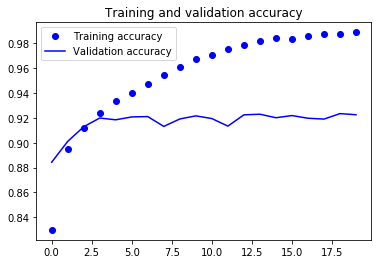

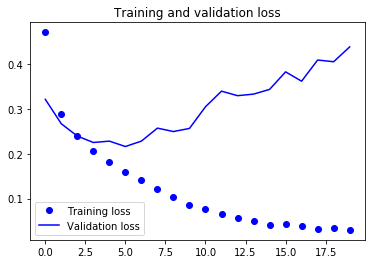

In [17]:
accuracy = fashion_train.history['acc']
val_accuracy = fashion_train.history['val_acc']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the above two plots, we can see that the validation accuracy almost became stagnant after 4-5 epochs and rarely increased at certain epochs. In the beginning, the validation accuracy was linearly increasing with loss, but then it did not increase much.

The validation loss shows that this is the sign of overfitting, similar to validation accuracy it linearly decreased but after 4-5 epochs, it started to increase. This means that the model tried to memorize the data and succeeded.

With this in mind, it's time to introduce some dropout into our model and see if it helps in reducing overfitting.


# Adding Dropout into the Network
we can add a dropout layer to overcome the problem of overfitting to some extent. Dropout randomly turns off a fraction of neurons during the training process, reducing the dependency on the training set by some amount. How many fractions of neurons we want to turn off is decided by a hyperparameter, which can be tuned accordingly. This way, turning off some neurons will not allow the network to memorize the training data since not all the neurons will be active at the same time and the inactive neurons will not be able to learn anything.

So let's create, compile and train the network again but this time with dropout. And we'll run it for 20 epochs with a batch size of 64.

In [0]:
batch_size = 64
epochs = 20
num_classes = 10

In [19]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.25))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Dropout(0.4))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))           
fashion_model.add(Dropout(0.3))
fashion_model.add(Dense(num_classes, activation='softmax'))

W0716 05:19:54.714546 140549233768320 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [0]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [22]:
fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 111us/step - loss: 0.6097 - acc: 0.7739 - val_loss: 0.3761 - val_acc: 0.8612
Epoch 2/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.3864 - acc: 0.8559 - val_loss: 0.3076 - val_acc: 0.8876
Epoch 3/20
48000/48000 [==============================] - 5s 100us/step - loss: 0.3347 - acc: 0.8761 - val_loss: 0.2809 - val_acc: 0.8956
Epoch 4/20
48000/48000 [==============================] - 5s 100us/step - loss: 0.3062 - acc: 0.8872 - val_loss: 0.2682 - val_acc: 0.8988
Epoch 5/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.2904 - acc: 0.8938 - val_loss: 0.2454 - val_acc: 0.9106
Epoch 6/20
48000/48000 [==============================] - 5s 102us/step - loss: 0.2696 - acc: 0.8996 - val_loss: 0.2399 - val_acc: 0.9120
Epoch 7/20
48000/48000 [==============================] - 5s 100us/step - loss: 0.2611 - acc: 0.9019 - val_loss: 0.2419 - va

# Save the model

In [0]:
fashion_model.save("fashion_model_dropout.h5py")

Finally, let's also evaluate our new model and see how it performs!

In [24]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)

10000/10000 [==============================] - 1s 70us/step


In [25]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.2365914911031723
Test accuracy: 0.9157


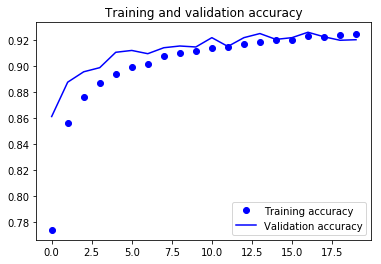

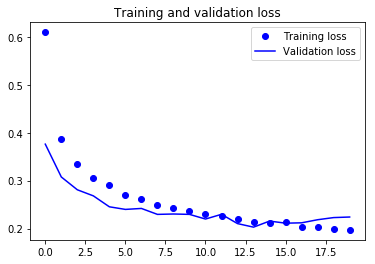

In [26]:
accuracy = fashion_train_dropout.history['acc']
val_accuracy = fashion_train_dropout.history['val_acc']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Finally, we can see that the validation loss and validation accuracy both are in sync with the training loss and training accuracy. Even though the validation loss and accuracy line are not linear, but it shows that our model is not overfitting: the validation loss is decreasing and not increasing, and there is not much gap between training and validation accuracy.
Therefore, we can say that our model's generalization capability became much better since the loss on both test set and validation set was only slightly more compared to the training loss.


# Predict Labels

In [0]:
predicted_classes = fashion_model.predict(test_X)

In [0]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [29]:
predicted_classes.shape, test_Y.shape

((10000,), (10000,))

Found 9145 correct labels


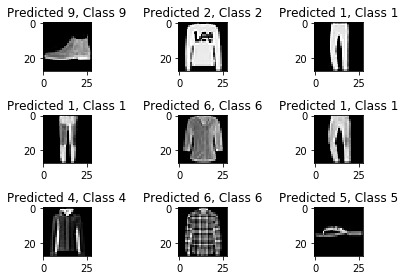

In [30]:
correct = np.where(predicted_classes==test_Y)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 807 incorrect labels


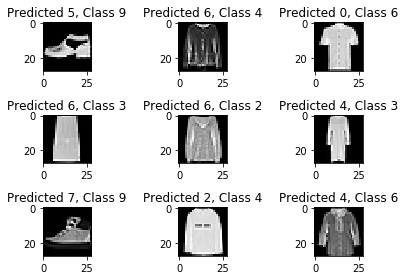

In [33]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()